Import package

In [ ]:
import numpy as np
from numpy.linalg import norm
import pickle
from tqdm import tqdm, tqdm_notebook
import os
import random
import time
import math
import tensorflow
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, GlobalAveragePooling2D

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
import tarfile
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors

Mount to Google drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Download dataset zip file and decompress

In [ ]:
filename = "drive/My Drive/nyu second semester/artificial intelligence/ai_project/Cody/LFW/lfw-deepfunneled.tgz"
tf = tarfile.open(filename)
tf.extractall('drive/My Drive/nyu second semester/artificial intelligence/ai_project/Cody/LFW/deepfunneled')

Load pre-trained CNN

In [ ]:
def model_picker(name):
    if (name == 'vgg16'):
        model = VGG16(weights='imagenet',
                      include_top=False,
                      input_shape=(250, 250, 3),
                      pooling='max')
    elif (name == 'vgg19'):
        model = VGG19(weights='imagenet',
                      include_top=False,
                      input_shape=(250, 250, 3),
                      pooling='max')
    elif (name == 'mobilenet'):
        model = MobileNet(weights='imagenet',
                          include_top=False,
                          input_shape=(250, 250, 3),
                          pooling='max',
                          depth_multiplier=1,
                          alpha=1)
    elif (name == 'inception'):
        model = InceptionV3(weights='imagenet',
                            include_top=False,
                            input_shape=(250, 250, 3),
                            pooling='max')
    elif (name == 'resnet'):
        model = ResNet50(weights='imagenet',
                         include_top=False,
                         input_shape=(250, 250, 3),
                        pooling='max')
    else:
        print("Specified model not available")
    return model

We choose VGG19

In [ ]:
model_architecture = 'vgg19'
model = model_picker(model_architecture)

80150528/80134624 [==============================] - 1s 0us/step


Get feature vectors

In [ ]:
def extract_features(img_path, model):
    input_shape = (250, 250, 3)
    img = image.load_img(img_path,
                         target_size=(input_shape[0], input_shape[1]))
    img_array = image.img_to_array(img)
    expanded_img_array = np.expand_dims(img_array, axis=0)
    preprocessed_img = preprocess_input(expanded_img_array)
    features = model.predict(preprocessed_img)
    flattened_features = features.flatten()
    normalized_features = flattened_features / norm(flattened_features)
    return normalized_features

In [ ]:
extensions = ['.jpg', '.JPG', '.jpeg', '.JPEG', '.png', '.PNG']

def get_file_list(root_dir):
    file_list = []
    for root, directories, filenames in os.walk(root_dir):
        for filename in filenames:
            if any(ext in filename for ext in extensions):
                filepath = os.path.join(root, filename)
                if os.path.exists(filepath):
                  file_list.append(filepath)
                else:
                  print(filepath)
    return file_list

In [ ]:
root_dir =r'C:\Users\djain\Documents\2022_Spring\6613 AI\project\lfw\lfw-deepfunneled\lfw_deepfunneled'
filenames = sorted(get_file_list(root_dir))
print(len(filenames))

13233


In [ ]:
standard_feature_list = []
for i in tqdm_notebook(range(len(filenames))):
    standard_feature_list.append(extract_features(filenames[i], model))

In [ ]:
batch_size = 128
datagen = tensorflow.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=preprocess_input)

generator = datagen.flow_from_directory(root_dir,
                                        target_size=(250, 250),
                                        class_mode=None,
                                        shuffle=False)

num_images = len(generator.filenames)
num_epochs = int(math.ceil(num_images / batch_size))

start_time = time.time()
feature_list = []
#feature_list = model.predict_generator(generator, num_epochs)
feature_list = model.predict(generator, num_epochs)
end_time = time.time()

Found 13233 images belonging to 5749 classes.


In [ ]:
for i, features in enumerate(feature_list):
    feature_list[i] = features / norm(features)

feature_list = feature_list.reshape(len(feature_list), -1)

print("Num images   = ", len(generator.classes))
print("Shape of feature_list = ", feature_list.shape)
print("Time taken in sec = ", end_time - start_time)

Num images   =  13233
Shape of feature_list =  (13233, 512)
Time taken in sec =  1818.6331593990326


Save and organize the results for future use

In [ ]:
filenames = [root_dir + '/' + s for s in generator.filenames]

In [ ]:
pickle.dump(generator.classes, open(r'C:\Users\djain\Documents\2022_Spring\6613 AI\project\lfw\class_ids-lfw.pickle', 'wb'))
pickle.dump(filenames,open(r'C:\Users\djain\Documents\2022_Spring\6613 AI\project\lfw\filenames-lfw.pickle', 'wb'))
pickle.dump(feature_list,open(r'C:\Users\djain\Documents\2022_Spring\6613 AI\project\lfw\features-lfw-' + model_architecture + '.pickle', 'wb'))


Use created VGG19 feature list

Add KNN search

Read the pickle file

In [ ]:
file = open('drive/My Drive/nyu second semester/artificial intelligence/ai_project/Cody/LFW/features-lfw-vgg19.pickle', 'rb')

all_features = pickle.load(file)

file.close()


In [ ]:
file = open('drive/My Drive/nyu second semester/artificial intelligence/ai_project/Cody/LFW/class_ids-lfw.pickle', 'rb')

all_labels = pickle.load(file)

file.close()


Get the nearest 20 faces

In [ ]:
nearest_20_faces = NearestNeighbors(n_neighbors=20, algorithm='auto').fit(all_features)
distances, indices = nearest_20_faces.kneighbors(all_features)

In [ ]:
list_file = get_file_list('drive/My Drive/nyu second semester/artificial intelligence/ai_project/Cody/LFW/deepfunneled')

Write useful functions for query later

In [ ]:
def generate_input_path(name):
    name_string = "drive/My Drive/nyu second semester/artificial intelligence/ai_project/Cody/LFW/deepfunneled/lfw-deepfunneled/"
    input_query = name_string+name+"/"+name+"_0001.jpg"
    return input_query

In [ ]:
def get_input_index(input_query):
  for i in range(len(list_file)):
    if list_file[i]==input_query:
      return i

In [ ]:
def get_name(path):
  search_key = 'drive/My Drive/nyu second semester/artificial intelligence/ai_project/Cody/LFW/deepfunneled/lfw-deepfunneled/'
  len_key = len(search_key)
  if path.startswith(search_key):
    face_name = path[len_key:path.find('.',len_key,-1)]
    return face_name

In [ ]:
def plot_20_faces(index):
  fig = plt.figure(figsize=(20, 20))
  rows = 10
  columns = 2
  for i in range(20):
    fig.add_subplot(rows, columns, i+1)
    output_img = mpimg.imread(list_file[indices[index][i]])
    title = get_name(list_file[indices[index][i]])
    plt.xticks([]), plt.yticks([])
    plt.title(title)
    plt.imshow(output_img)

TEN queries from professor

Query 1: Albert Costa

In [ ]:
query1 = generate_input_path("Albert_Costa")
index1 = get_input_index(query1)

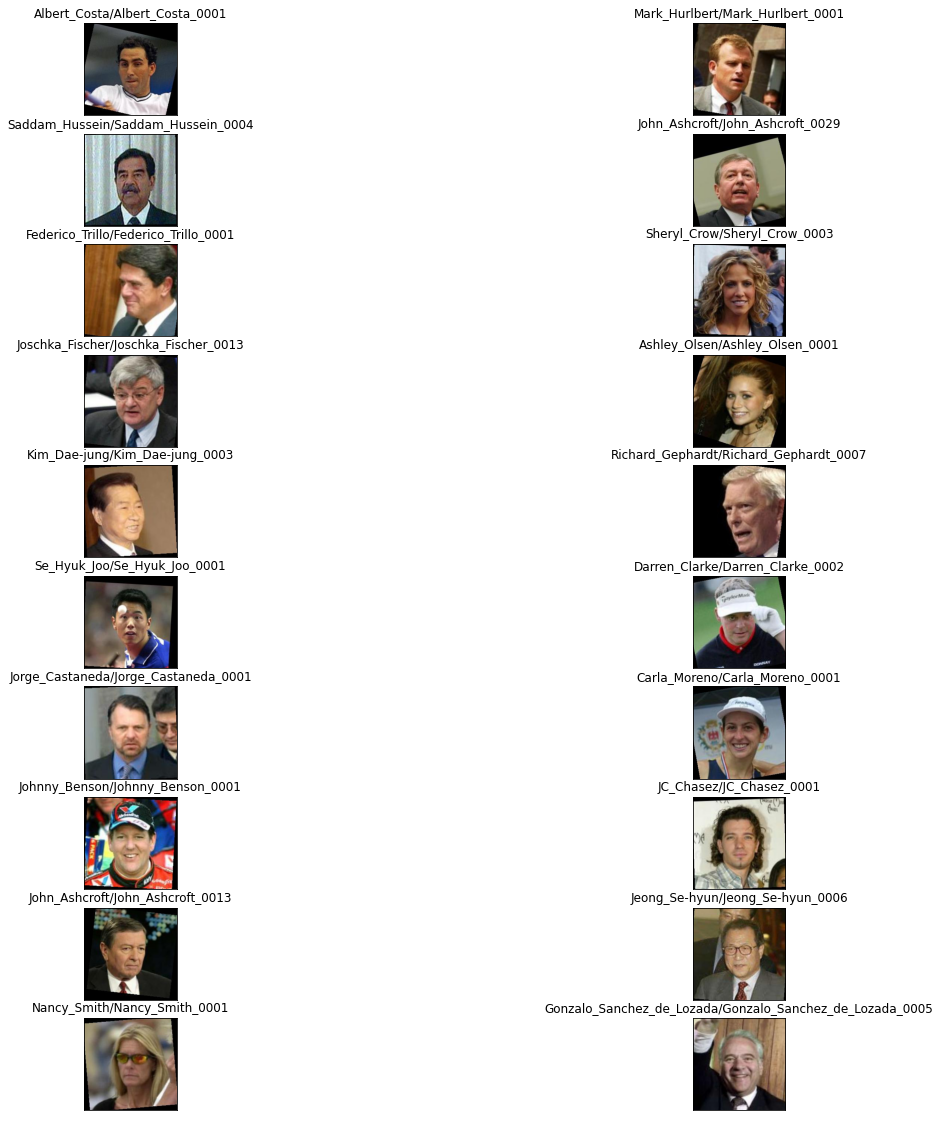

In [ ]:
plot_20_faces(index1)

Query 2: Angela Bassett

In [ ]:
query2 = generate_input_path("Angela_Bassett")
index2 = get_input_index(query2)

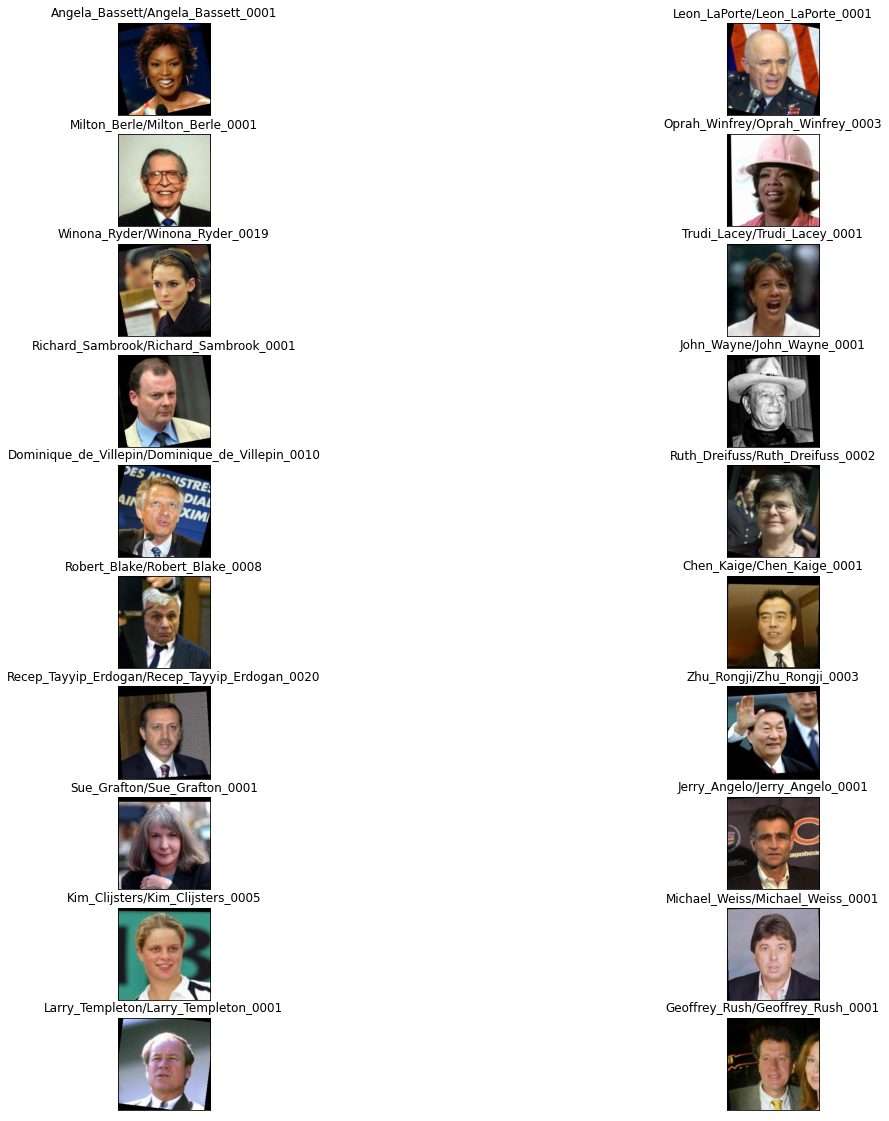

In [ ]:
plot_20_faces(index2)

Query 3: Arminio Fraga

In [ ]:
query3 = generate_input_path("Arminio_Fraga")
index3 = get_input_index(query3)

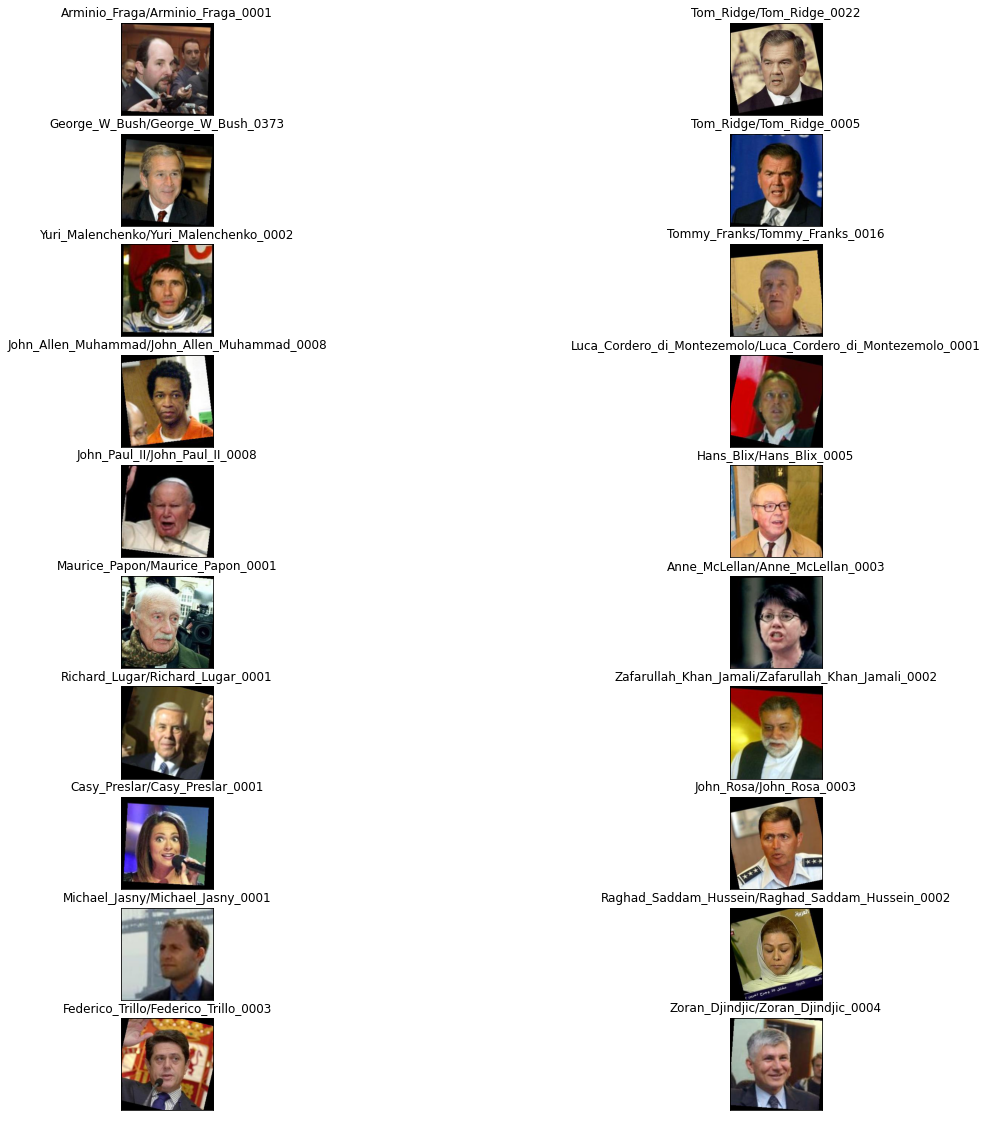

In [ ]:
plot_20_faces(index3)

Query 4: Billy Crystal

In [ ]:
query4 = generate_input_path("Arminio_Fraga")
index4 = get_input_index(query4)

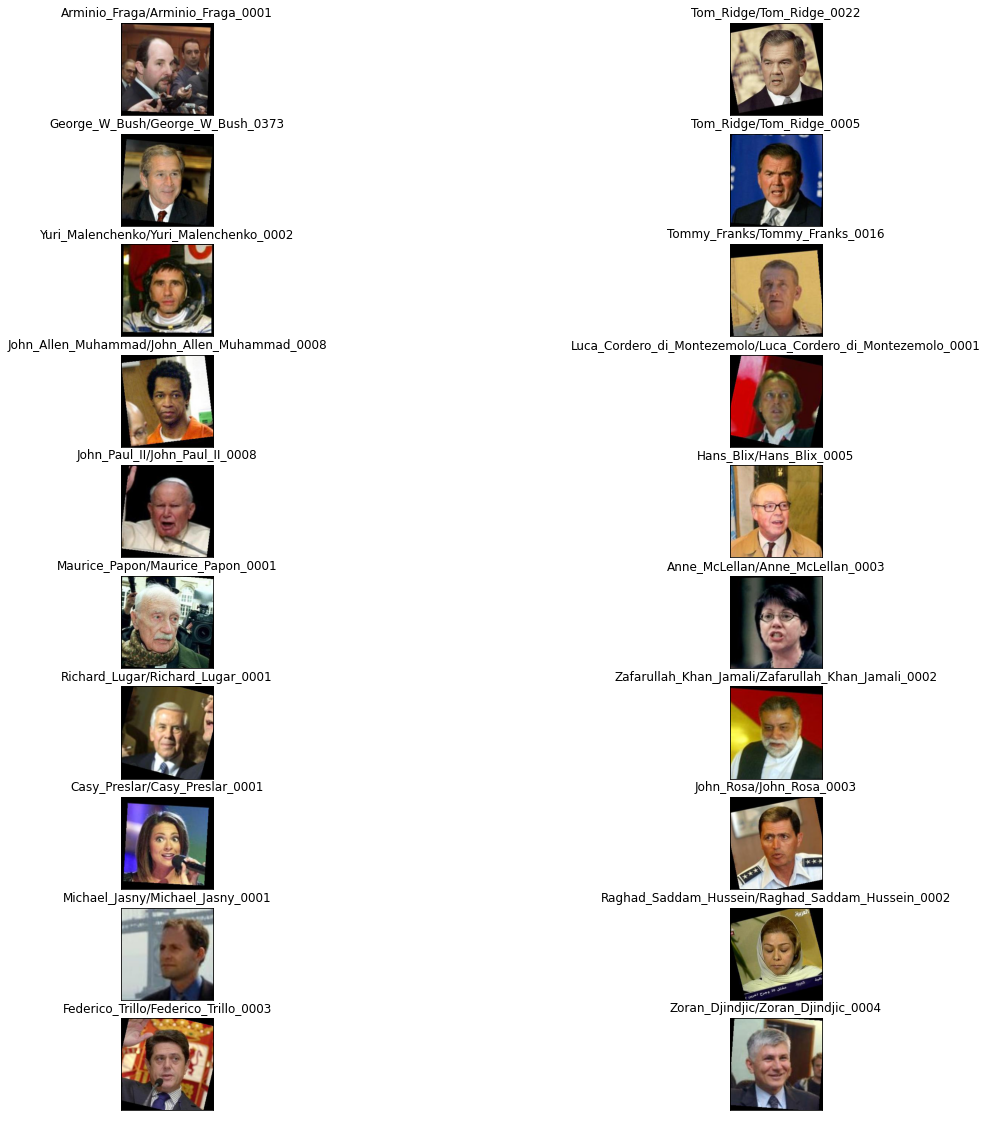

In [ ]:
plot_20_faces(index4)

Query 5: Bob Graham

In [ ]:
query5 = generate_input_path("Bob_Graham")
index5 = get_input_index(query5)

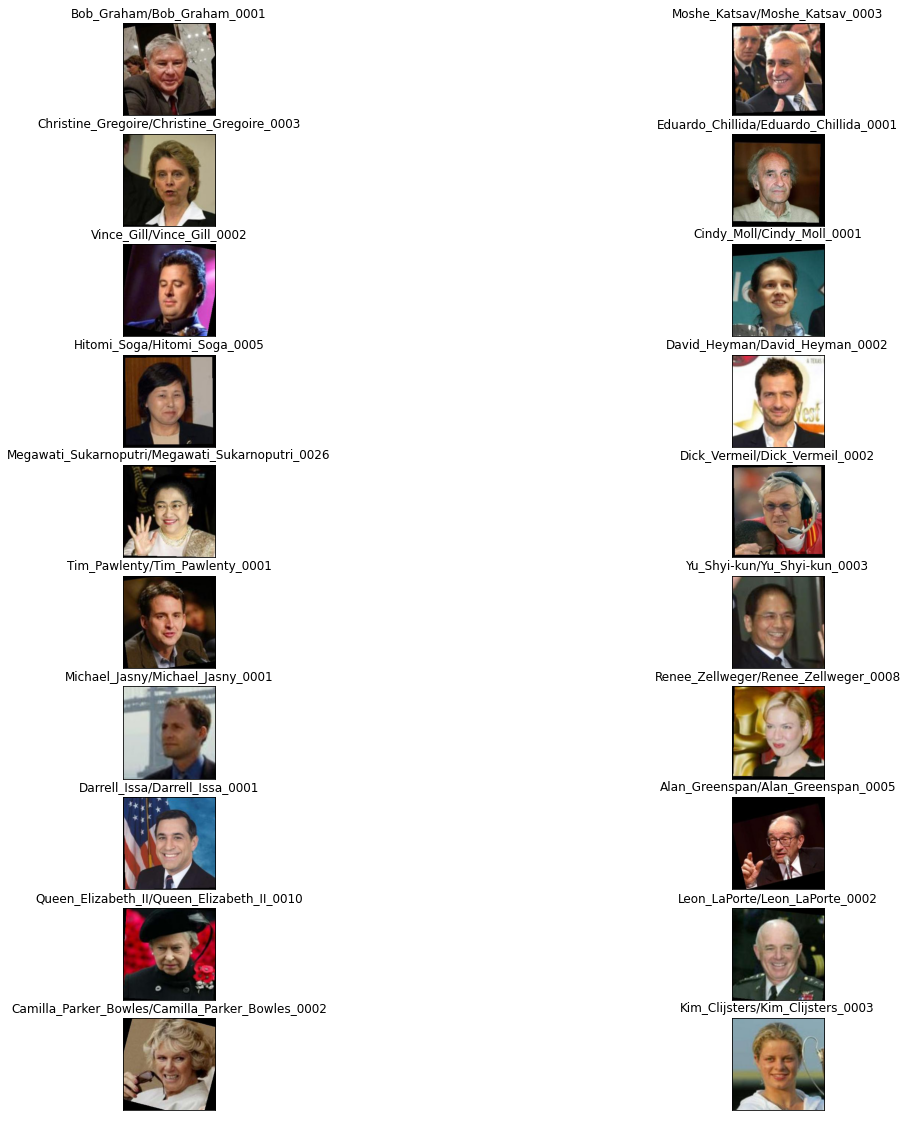

In [ ]:
plot_20_faces(index5)

Query 6: Boris Becker

In [ ]:
query6 = generate_input_path("Boris_Becker")
index6 = get_input_index(query6)

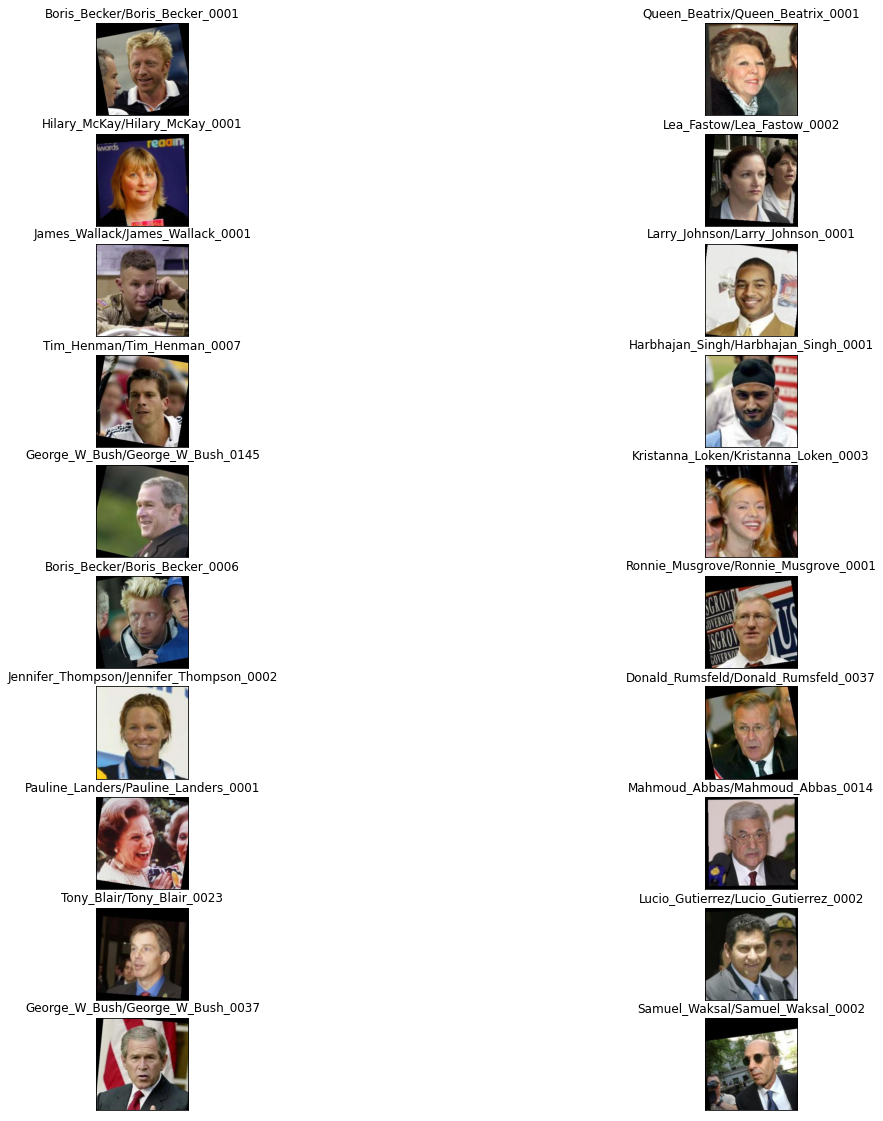

In [ ]:
plot_20_faces(index6)

Query 7: Bulent Ecevit

In [ ]:
query7 = generate_input_path("Bulent_Ecevit")
index7 = get_input_index(query7)

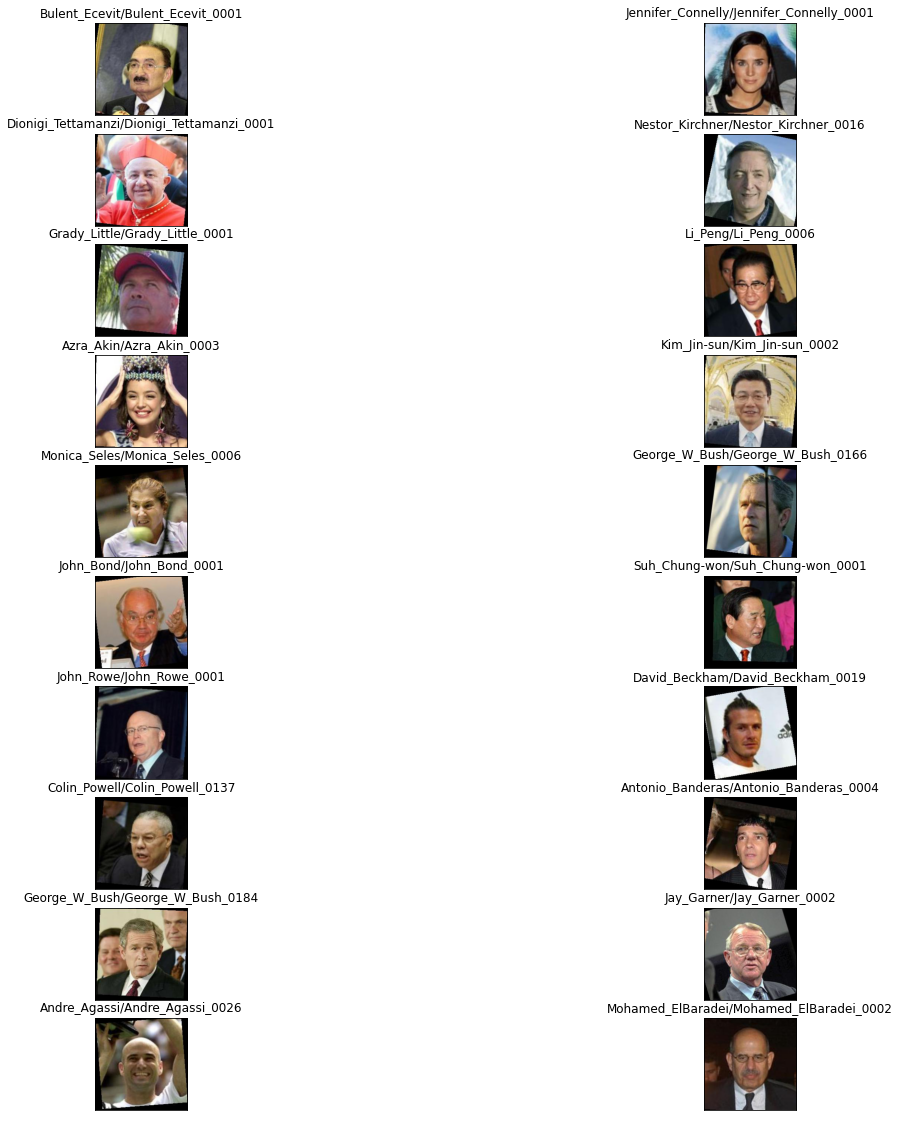

In [ ]:
plot_20_faces(index7)

Query 8: Calista Flockhart

In [ ]:
query8 = generate_input_path("Calista_Flockhart")
index8 = get_input_index(query8)

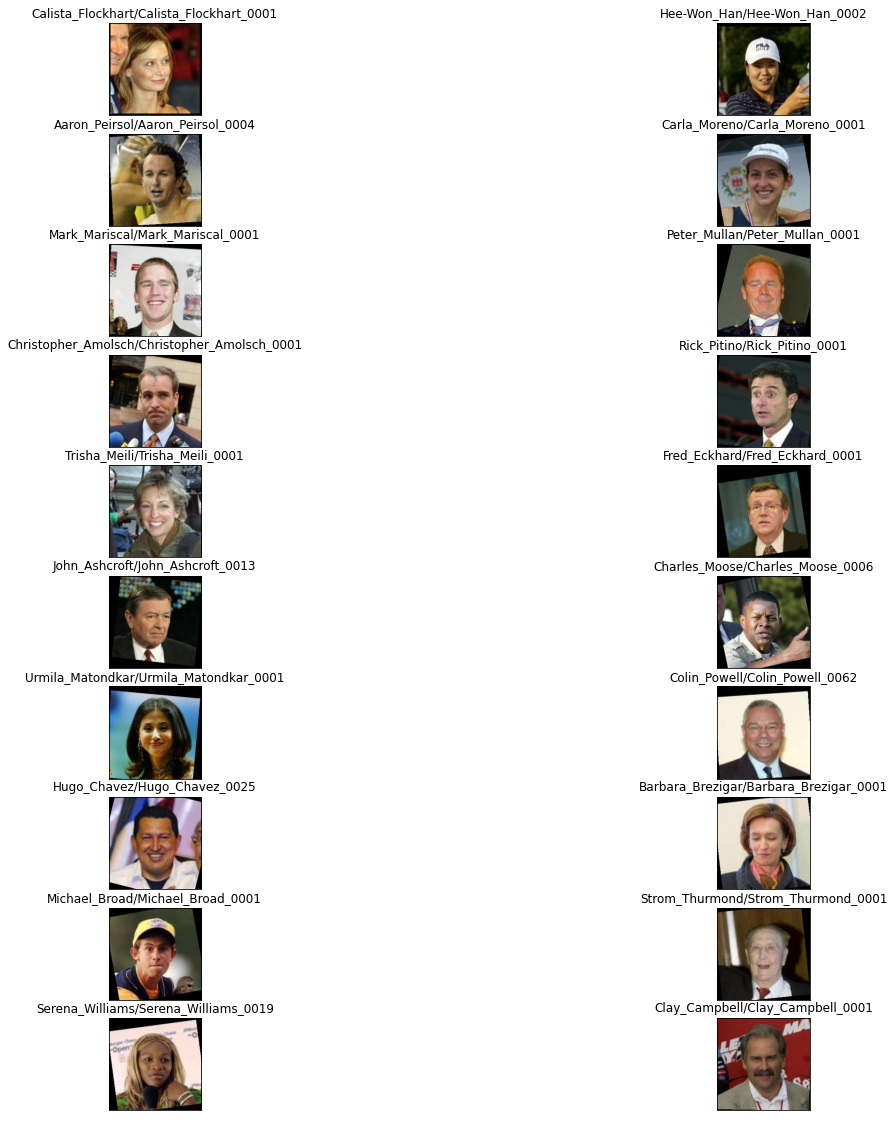

In [ ]:
plot_20_faces(index8)

Query 9: Cameron Diaz

In [ ]:
query9 = generate_input_path("Cameron_Diaz")
index9 = get_input_index(query9)

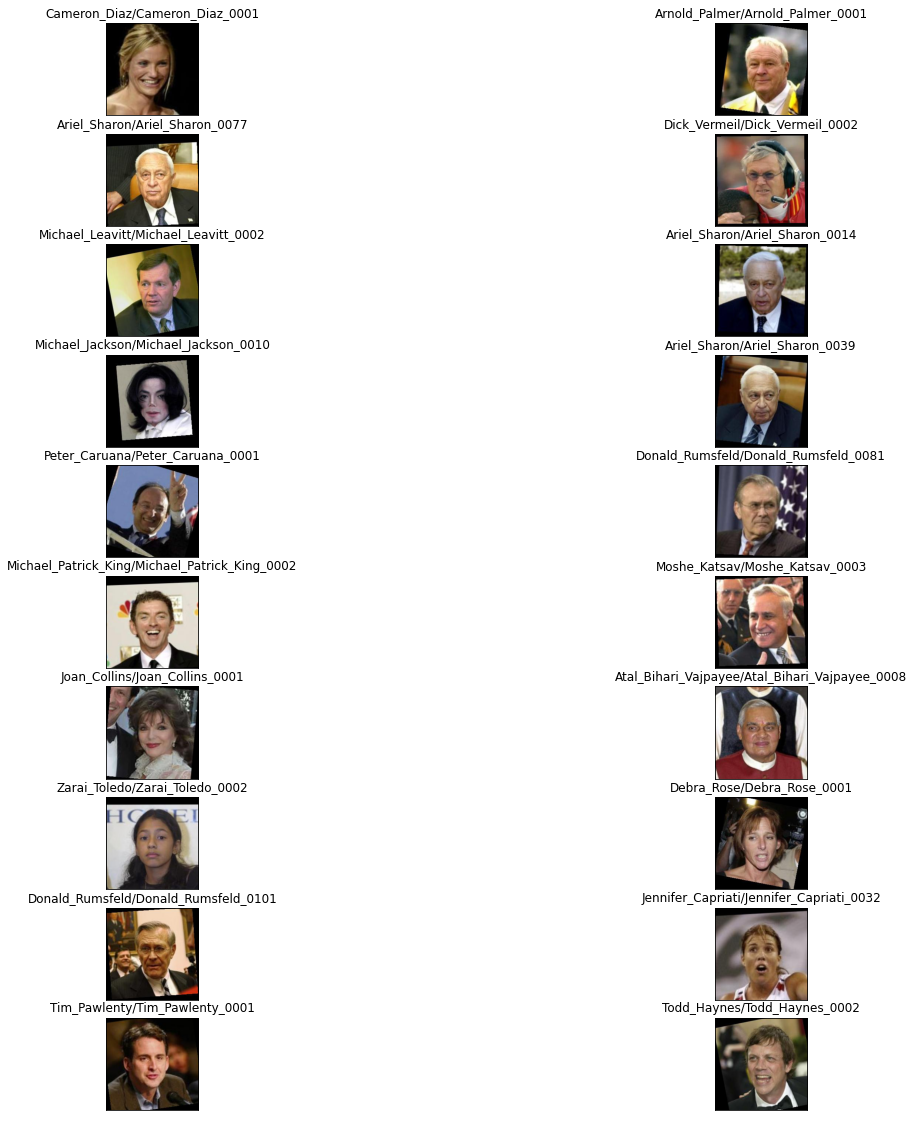

In [ ]:
plot_20_faces(index9)

Query 10: Carmen Electra

In [ ]:
query10 = generate_input_path("Carmen_Electra")
index10 = get_input_index(query10)

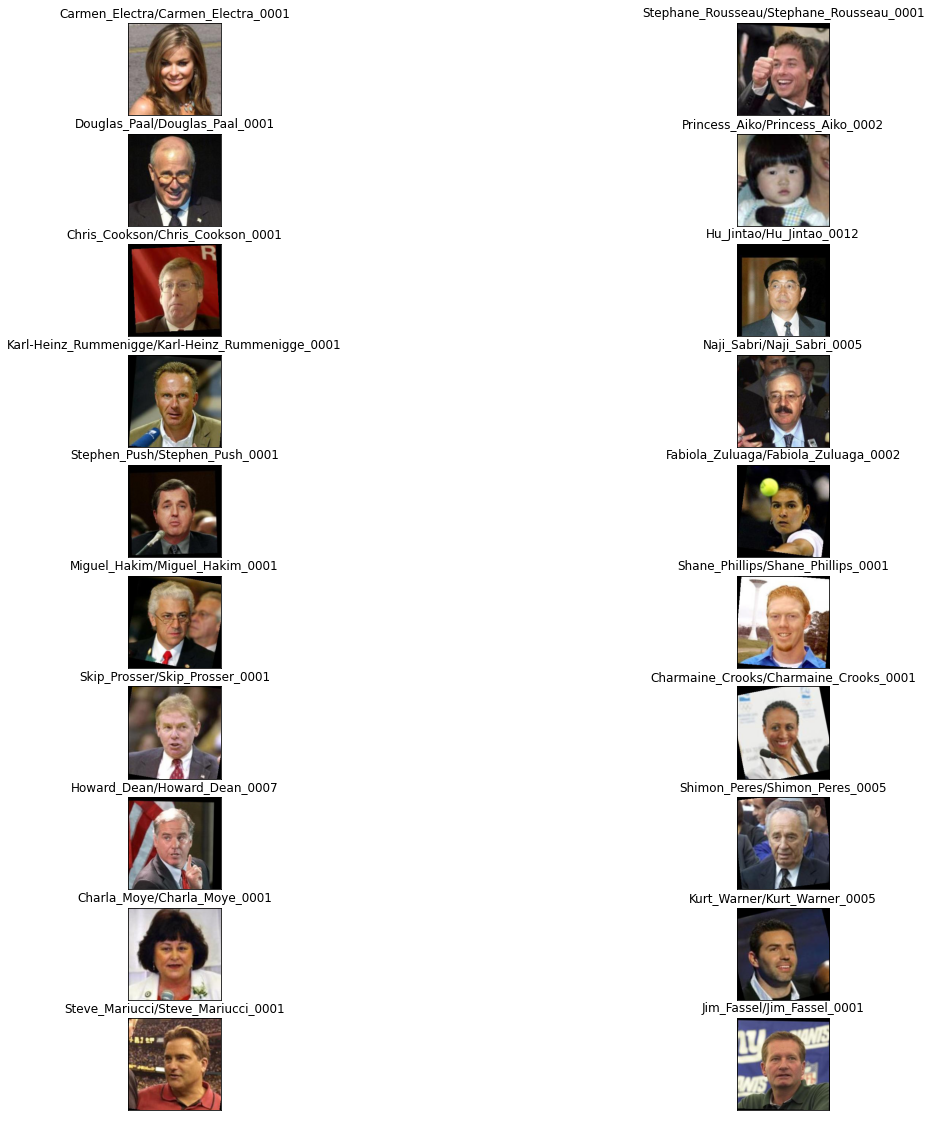

In [ ]:
plot_20_faces(index10)